# VGG16 model for predicting stage based on images

In [25]:
#Importing libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Importing Dataframe
path='Small Img'
df=pd.read_csv('2012_2019_PlatteRiverWeir_features_merged_all.csv')
df=df.iloc[:,2:7].drop(columns=[' Agency',' SiteNumber',' TimeZone'])
df.rename(columns={' Filename':'Filename', ' Stage':'Stage'},inplace=True)
df['Filename'] = df['Filename'].apply(lambda x: f"{path}/{x}")
df

,Filename,Stage
0,Small Img/StateLineWeir_20120609_Farrell_001.jpg,2.99
1,Small Img/StateLineWeir_20120609_Farrell_002.jpg,2.99
2,Small Img/StateLineWeir_20120609_Farrell_003.jpg,2.96
3,Small Img/StateLineWeir_20120609_Farrell_004.jpg,2.94
4,Small Img/StateLineWeir_20120609_Farrell_005.jpg,2.94
...,...,...
42054,Small Img/StateLineWeir_20191011_Farrell_409.jpg,2.54
42055,Small Img/StateLineWeir_20191011_Farrell_410.jpg,2.54
42056,Small Img/StateLineWeir_20191011_Farrell_411.jpg,2.54
42057,Small Img/StateLineWeir_20191011_Farrell_412.jpg,2.54


In [4]:
#Definition of train and test sets
train, test = train_test_split(df, test_size=0.2)

In [5]:
#Definition of parameters
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=32
epochs=30

In [6]:
#Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train, 
    x_col='Filename',
    y_col='Stage',
    class_mode='raw',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    subset='training'
)

Found 26918 validated image filenames.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='Filename',
    y_col='Stage',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

validation_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='Filename',
    y_col='Stage',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size,
    subset='validation'
)

Found 8412 validated image filenames.
Found 6729 validated image filenames.


In [8]:
#Definition of earlystop parameter
earlystop = EarlyStopping(patience=4)

In [9]:
#Plotting 5 image samples
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

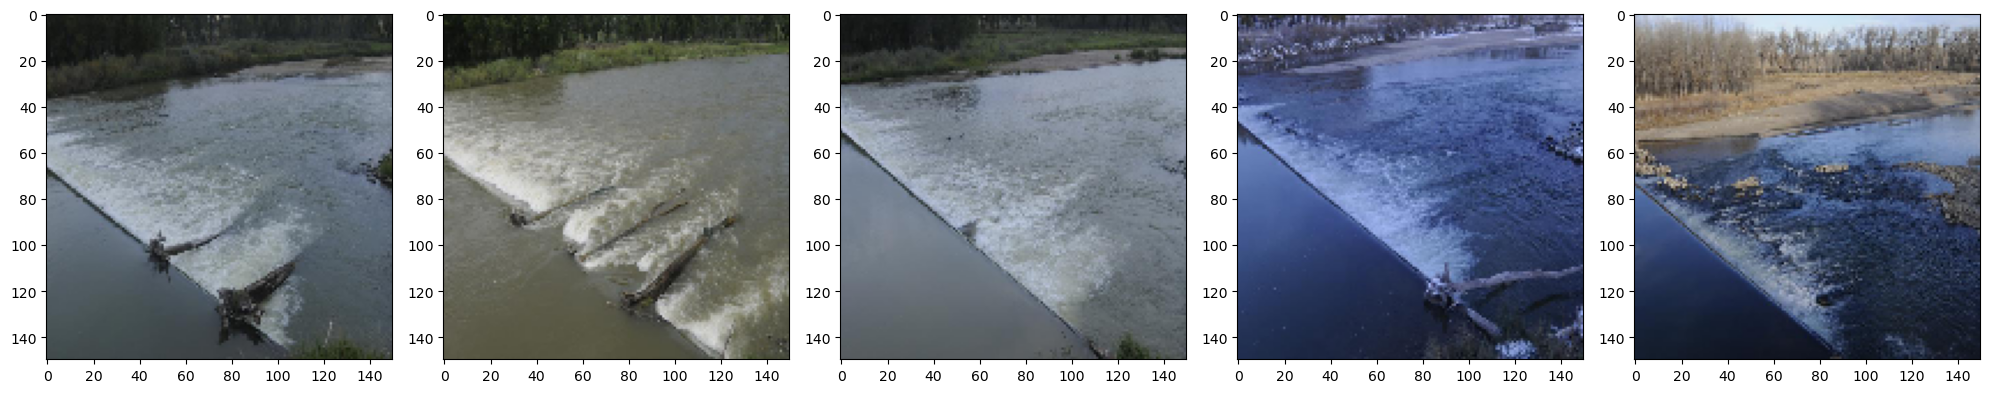

In [10]:
plotImages(train_generator[0][0])

In [12]:
#Defining vgg16 as base model
modelo_base1 = VGG16(input_shape=(150, 150, 3),
                include_top=False,
                weights=None
                )

In [13]:
#Making layers trainable
modelo_base1.trainable = True

In [14]:
modelo_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
#Defining feature batches
image_batch, label_batch = next(iter(train_generator))
feature_batch = modelo_base1(image_batch)

In [16]:
#Adding last layers
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [17]:
prediction_layer = Dense(1,activation='linear')
prediction_batch = prediction_layer(feature_batch_average)

In [18]:
#defining inputs and outputs
inputs = Input(shape=(150, 150, 3))
x = modelo_base1(inputs, training=False)
x = global_average_layer(x)
x = Dropout(0.5)(x)
outputs = prediction_layer(x)
modelo1 = Model(inputs, outputs)

In [19]:
#Compiling model
from sklearn.metrics import r2_score
modelo1.compile(optimizer='adam',
              loss='mse',
              metrics=[r2_score],
              run_eagerly=True
              )

In [20]:
modelo1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________

In [21]:
#Training model
history = modelo1.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[earlystop]
    )

Epoch 1/30
842/842 [==============================] - 520s 611ms/step - loss: 0.9446 - r2_score: -0.4586 - val_loss: 0.1333 - val_r2_score: 0.7715
Epoch 2/30
842/842 [==============================] - 503s 598ms/step - loss: 0.1394 - r2_score: 0.7577 - val_loss: 0.0585 - val_r2_score: 0.8966
Epoch 3/30
842/842 [==============================] - 502s 596ms/step - loss: 0.0915 - r2_score: 0.8416 - val_loss: 0.0291 - val_r2_score: 0.9507
Epoch 4/30
842/842 [==============================] - 501s 595ms/step - loss: 0.0752 - r2_score: 0.8714 - val_loss: 0.0266 - val_r2_score: 0.9549
Epoch 5/30
842/842 [==============================] - 503s 597ms/step - loss: 0.0638 - r2_score: 0.8904 - val_loss: 0.0124 - val_r2_score: 0.9781
Epoch 6/30
842/842 [==============================] - 503s 598ms/step - loss: 0.0579 - r2_score: 0.8988 - val_loss: 0.0170 - val_r2_score: 0.9698
Epoch 7/30
842/842 [==============================] - 504s 598ms/step - loss: 0.0527 - r2_score: 0.9090 - val_loss: 0.0568 

In [22]:
#Saving results
result=history.history
historydf=pd.DataFrame(result)
historydf

,loss,r2_score,val_loss,val_r2_score
0,0.944615,-0.458645,0.133288,0.771521
1,0.139368,0.757690,0.058525,0.896606
2,0.091514,0.841621,0.029113,0.950735
3,0.075190,0.871400,0.026638,0.954882
4,0.063769,0.890431,0.012360,0.978132
5,0.057929,0.898753,0.016987,0.969829
6,0.052708,0.908982,0.056804,0.895361
7,0.050771,0.911351,0.023560,0.959140
8,0.044677,0.922017,0.010066,0.982497
9,0.036555,0.936638,0.020953,0.961962


In [23]:
#Evaluating model
evaluation =modelo1.evaluate(test_generator, batch_size=batch_size)

263/263 [==============================] - 63s 238ms/step - loss: 0.0087 - r2_score: 0.9841


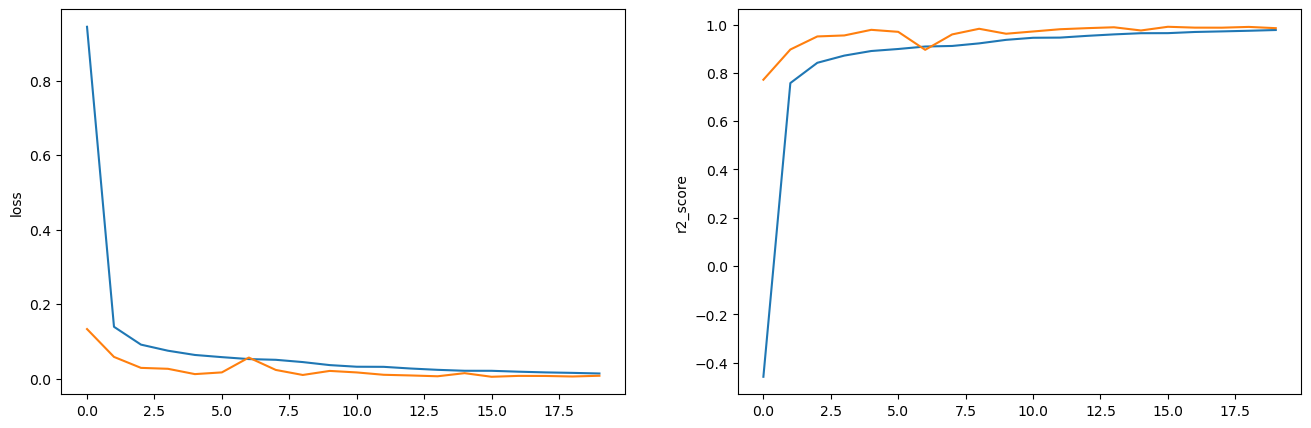

In [26]:
#Plotting model performance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(ax=axes[0],data=historydf, x=historydf.index, y="loss")
sns.lineplot(ax=axes[0],data=historydf, x=historydf.index, y="val_loss")
sns.lineplot(ax=axes[1],data=historydf, x=historydf.index, y="r2_score")
sns.lineplot(ax=axes[1],data=historydf, x=historydf.index, y="val_r2_score")

plt.show()

In [ ]:
#Saving model for webapp implementation
#modelo1.save('VGG')

INFO:tensorflow:Assets written to: VGG\assets


INFO:tensorflow:Assets written to: VGG\assets
